In [262]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.stats import poisson, uniform, norm, cauchy, gaussian_kde

sys.version # check which python interpreter is used  

'3.6.0 (v3.6.0:41df79263a11, Dec 22 2016, 17:23:13) \n[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]'

# Ramp-up Model

Let's model some ramp-ups. :)

We use the option that we only send a part of the traffic to a/b testing during ramp-up, traffic that does not go to a/b testing will by default be the control. After reaching a/b testing, we always make a 50%/50% split of treatment and control.
We simulate in a way that ramp-up happens on day 0 (10% ), day 5 (30%), and day 10 (50%). This is illustrated in the following table.

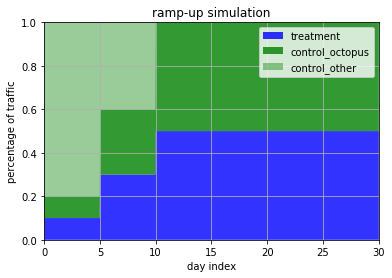

In [263]:
x = np.linspace(0, 30, 1000)
y0 = 0
y1 = [0.1 if i<5 else
      0.3 if i<10 else
      0.5 for i in x]
y2 = [0.2 if i<5 else
      0.6 if i<10 else
      1.0 for i in x]
y3 = 1

fig, ax = plt.subplots()
ax.fill_between(x, y0, y1, facecolor='blue', interpolate=True, alpha=0.8, label="treatment")
ax.fill_between(x, y1, y2, facecolor='green', interpolate=True, alpha=0.8, label="control_octopus")
ax.fill_between(x, y2, y3, facecolor='green', interpolate=True, alpha=0.4, label="control_other")
ax.set_xlim(0, 30)
ax.set_ylim(0, 1)

ax.set_xlabel('day index')
ax.set_ylabel('percentage of traffic')
ax.set_title('ramp-up simulation')
ax.legend()
ax.grid(True)

plt.show()

# Ramp-up Analysis

Here we will compare three approaches of analysis:
* Approach **Straightforward**: Only analyse the period when traffic is split 50/50, don't consider the ramp-up period.
* Approach **Remove ramp-up data**: Analyse the period when traffic is split 50/50 and remove the assignments from the ramp-up period (risk to remove a big part of the assignments).
* Approach **Exposure time**: Consider the whole period (ramp-up + 50/50 split) and use a fixed exposure time (based on actual experiment runtime) for each assignment.

Please refer to epic Ramp-ups: https://techjira.zalando.net/browse/OCTO-1613

We will evaluate the three analysis approaches in the following sections. Here we first define one method per approach that selects the data for analysis.

In [264]:
valid_exposure_time = 14  # two weeks

def approach_staightforward(data):
    data_for_analysis = data[data.time>=10].reset_index()
    return data_for_analysis

def approach_remove_rampup_data(data):
    data_for_analysis = data[data.time>=10].reset_index()
    first_day_per_entity = data.groupby(['entity'])['time'].min().reset_index()
    for i in range(len(data_for_analysis)):
        entity = data.loc[i, 'entity']
        variant = data.loc[i, 'variant']
        if variant == "B":
            first_day = first_day_per_entity[first_day_per_entity['entity']==entity].iloc[0, 1]
            if first_day < 10:
                data_for_analysis.drop(i, inplace=True)
    return data_for_analysis

def approach_exposure_time(data):
    data_for_analysis = data.copy()
    first_day_per_entity = data.groupby(['entity'])['time'].min().reset_index()
    for i in range(len(data_for_analysis)):
        entity = data.loc[i, 'entity']
        variant = data.loc[i, 'variant']
        day = data.loc[i, 'time']
        if variant == "B":
            first_day = first_day_per_entity[first_day_per_entity['entity']==entity].iloc[0, 1]
            if day - first_day > valid_exposure_time:
                data_for_analysis.drop(i, inplace=True)
    return data_for_analysis.reset_index()

# Simulation Data

We generate control and treatment with same normal distribution.

In [265]:
seed = 7
days = 30
total_entities = 10000 
averageVisitPerEntity = 3
base = 0.5
delta = 0
scale = 0.1

np.random.seed(seed)
random.seed(7)

def _randomNumberPoisson(lam):
    lower = poisson.pmf(0, lam)
    return poisson.ppf(uniform.rvs(size=1, loc=lower, scale=1 - lower), lam)

def ramp_up_simulation_data():
    assignment = pd.DataFrame({'entity': range(total_entities),
                               'variant': np.random.choice(['A', 'B'], size=total_entities, p=[0.5, 0.5])})
    all_data = pd.DataFrame()
    for e in range(total_entities):
        n_for_e = int(_randomNumberPoisson(averageVisitPerEntity))
        if n_for_e > days:
            n_for_e = days
        timePoints = np.random.choice(days, size=n_for_e, replace=False)
        normal_shifted_rv = norm.rvs(size=n_for_e, loc=base, scale=scale)
        if assignment.variant[assignment.entity == e].iloc[0] == 'B':
            normal_shifted_rv = norm.rvs(size=n_for_e, loc=base+delta, scale=scale)
        df = pd.DataFrame({
            'entity': e,
            'normal_shifted': normal_shifted_rv,
            'time': timePoints
        })
        all_data = all_data.append(df, ignore_index=True)
    all_data = pd.merge(all_data, assignment, on='entity')
    
    for index, row in all_data.iterrows():
        randint = random.randrange(10)
        if row['time'] < 5 and randint < 8:
            all_data.drop(index, inplace=True)
        elif 5 <= row['time'] < 10 and randint < 4:
            all_data.drop(index, inplace=True)
            
    return all_data.reset_index()

In [266]:
data = ramp_up_simulation_data()
data.head()

,index,entity,normal_shifted,time,variant
0,0,0,0.440493,5,A
1,1,0,0.262855,17,A
2,2,0,0.332676,27,A
3,3,0,0.612572,15,A
4,4,0,0.483241,23,A


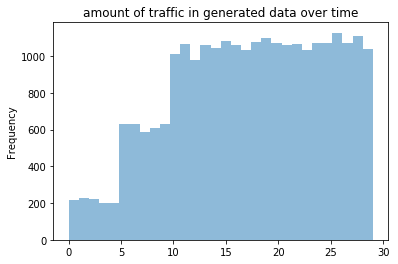

In [267]:
data.time.plot.hist(alpha=0.5, bins=30, title='amount of traffic in generated data over time')
plt.show()

Let's define a utility function that build a dataframe of kpi per variant.

In [268]:
def to_KPI_per_variant(df):
    kpi_A = df[df.variant == "A"]["normal_shifted"].reset_index(drop=True)
    kpi_B = df[df.variant == "B"]["normal_shifted"].reset_index(drop=True)
    data = pd.concat([kpi_A, kpi_B], axis=1, keys=['variant A', 'variant B'])
    return data[['variant A', 'variant B']]

We can use this utility function to look at the distribution of kpis for the two variants.

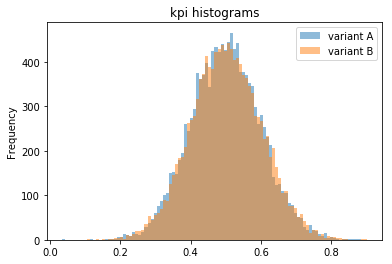

In [269]:
to_KPI_per_variant(data).plot.hist(alpha=0.5, bins=100, title="kpi histograms")
plt.show()

We can see that kpis of the two variant are normally distributed with mean 0.5.

# Effect of Exposure

One propery we want to model is the effect of exposure. If an entity is exposed to treatment for a long period, we might get a decayed kpi value from this enityt because he/she is used to the behaviour. We model this effect by a flipped logistic function, but with a smoother change. Again, we assume the changing point of exposure effect is centered at day 18. 

This effect of exposure is assumed to appear in the treatment gorup. While using a mocked function here, we will also investigate the function of exposure per kpi in real data. 

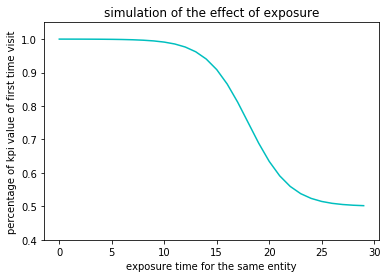

In [270]:
inflection_point = 18
def effect_of_exposure(array_of_days):
    k = 0.5
    return 0.5 / (1 + np.exp(-k*(inflection_point-array_of_days))) + 0.5

x = np.arange(30)
y = effect_of_exposure(x)
            
plt.plot(x, y, 'c-')
plt.ylim([0.4, 1.05])
plt.xlabel("exposure time for the same entity")
plt.ylabel("percentage of kpi value of first time visit")
plt.title("simulation of the effect of exposure")
plt.show()

In [271]:
def add_effect_of_exposure(data):
    first_day_per_entity = data.groupby(['entity'])['time'].min().reset_index()
    for i in range(len(data)):
        entity = data.loc[i, 'entity']
        day = data.loc[i, 'time']
        variant = data.loc[i, 'variant']
        if variant == 'B': # only add effect to the treatment
            first_day = first_day_per_entity[first_day_per_entity['entity']==entity].iloc[0, 1]
            time_of_exposure = day - first_day
            percentage_remained = effect_of_exposure(time_of_exposure)
            # print(entity, percentage_remained)
            data.set_value(i, 'normal_shifted', data.loc[i, 'normal_shifted'] * percentage_remained)
    return data

And let's look at how the kpis are distributed now after adding the mocked effect of exposure.

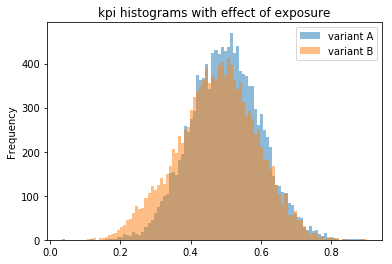

In [272]:
data_with_eoe = add_effect_of_exposure(data)
to_KPI_per_variant(data_with_eoe).plot.hist(alpha=0.5, bins=100, title="kpi histograms with effect of exposure")
plt.show()

Due to effect of exposure, we observed that the distribution of kpi in treatment group has changed. The modal still appears where the original mean were, however, the distribution are wider and skewed toward 0.

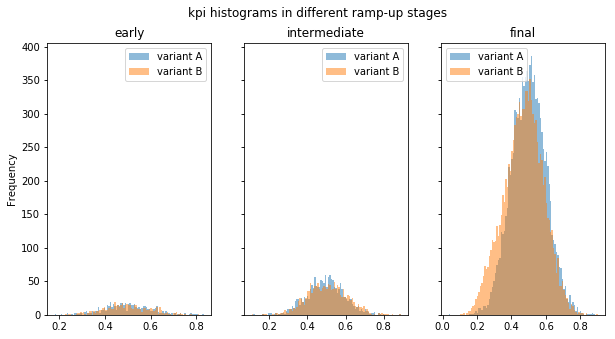

In [273]:
def plot_by_stage(data, title):
    data_with_eoe_grouped_by_stage = data.assign(stage='final')
    for i in range(len(data_with_eoe_grouped_by_stage)):
        day = data_with_eoe_grouped_by_stage.loc[i, 'time']
        if day < 5:
            data_with_eoe_grouped_by_stage.set_value(i, 'stage', 'early')
        elif 5<= day < 10:
            data_with_eoe_grouped_by_stage.set_value(i, 'stage', 'intermediate')

    data_by_stages = [
        (data_with_eoe_grouped_by_stage[data_with_eoe_grouped_by_stage.stage=='early'], 'early'),
        (data_with_eoe_grouped_by_stage[data_with_eoe_grouped_by_stage.stage=='intermediate'], 'intermediate'),
        (data_with_eoe_grouped_by_stage[data_with_eoe_grouped_by_stage.stage=='final'], 'final')
    ]

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5), sharey=True)
    for data, axis in zip(data_by_stages, axes):
        to_KPI_per_variant(data[0]).plot.hist(alpha=0.5, bins = 100, ax=axis)
        axis.set_title(data[1])
    fig.suptitle(title)
    plt.show()
    return

plot_by_stage(data_with_eoe, "kpi histograms in different ramp-up stages")

The distribution per stage shows that most of the exposure effect happens in the final 50/50 stage, while the effect is not obvious during ramp-up phases.

We will now investigate if the treatment and control group are comparable in early, intermediate and final stages for these approaches.

In [274]:
data1 = approach_staightforward(data_with_eoe)
data2 = approach_remove_rampup_data(data_with_eoe)
data3 = approach_exposure_time(data_with_eoe)
all_data = [(data1, 'Approach Staightforward'),
        (data2, 'Approach Remove ramp-up data'),
        (data3, 'Approach Exposure time')]

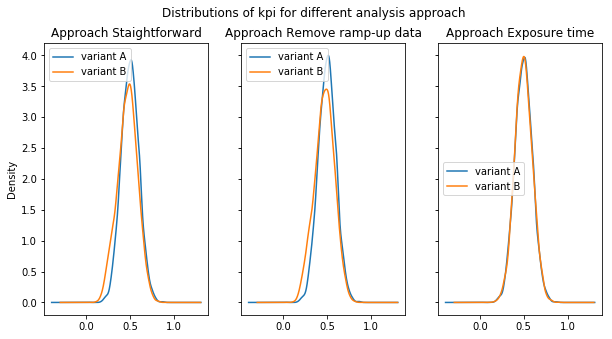

number of data:
Staightforward: 21223
Remove ramp-up data: 16534
Exposure time: 23212

percentage of treatment:
Staightforward: 49.84%
Remove ramp-up data: 49.72%
Exposure time: 44.90%


In [275]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5), sharey=True)

for data, axis in zip(all_data, axes):
    to_KPI_per_variant(data[0]).plot.kde(ax=axis)
    axis.set_title(data[1])
fig.suptitle("Distributions of kpi for different analysis approach")
plt.show()

n_ctr_1 = len(data1[data1.variant=='A'])
n_ctr_2 = len(data2[data2.variant=='A'])
n_ctr_3 = len(data3[data3.variant=='A'])
n_treat_1 = len(data1[data1.variant=='B'])
n_treat_2 = len(data2[data2.variant=='B'])
n_treat_3 = len(data3[data3.variant=='B'])

print("number of data:")
print("Staightforward:", len(data1))
print("Remove ramp-up data:", len(data2))
print("Exposure time:", len(data3))
print()
print("percentage of treatment:")
print("Staightforward: " + "{0:.2f}".format(n_treat_1/len(data1)*100) + "%")
print("Remove ramp-up data: " + "{0:.2f}".format(n_treat_2/len(data2)*100) + "%")
print("Exposure time: " + "{0:.2f}".format(n_treat_3/len(data3)*100) + "%")

We first observed that the improvement is not so obvious when removing ramp-up data. 

It highly depends on the function of effect of exposure. If the effect starts early (say day 5), then there will not be any difference removing ramp-up data or not, because those eneities visited during final phase will also have a big effect.

If the effect starts very late (say day 25), there is not much difference neither. This is because most of the entites will not encounter such effect, so removing ramp-up data or not does not influence the resulting distributions.

With a tuned function in between (day 18 in our case), we can see from the figures above that there can be a very small improvement if we remove ramp-up data, even though this improvement is insignificant.

Furthermore, the third approach obviously bring the distributions of two variants much closer. Although it is trivial here in simulation, it might be difficult to implement this feature in production. And the results also depends on the choice of the time range that we want to cut off.

Finally, regaring number of data for analysis, the approach of removing ramp-up data reduced plenty of data, while using the approach exposure time saves most of the traffic.
However, it is worth noting that the split of treatment/control is a little bit skewed by the approach exposure time, yet still within a reasonable range.

We will look into thess figures again once we can model real-world exposure effect per KPI.

# Seasonality Effect

Furthermore, we can add a seasonality effect on top of the exposure effect. Here we assume that there is mean shift of kpi value over time, in other words, there is a seasonal shift of interest. 

We use this to model the influence of long-runing experiments due to adding ramp-up phases, which leads to the shift of the kpi mean (e.g. run into a sale season). We model this by an increasement of kpi over time, the mean of kpi will shift toward 160% in the end, and the starting of change point is around day 5.

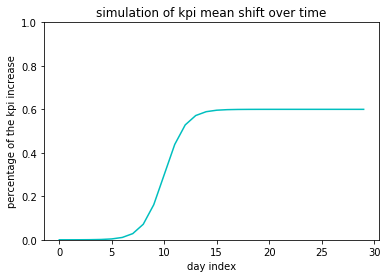

In [276]:
def seasonality_effect(x):
    return 0.6 / (1 + np.exp(-x+10))

x = np.arange(30)
y = seasonality_effect(x)
plt.plot(x, y, 'c-')
plt.ylim([0, 1])
plt.xlabel("day index")
plt.ylabel("percentage of the kpi increase")
plt.title("simulation of kpi mean shift over time")
plt.show()

In [277]:
def add_mean_shift_over_time(data):
    for i in range(len(data)):
        day = data.loc[i, 'time']
        kpi = data.loc[i, 'normal_shifted']
        percentage_increased = seasonality_effect(day)
        percentage_targeted = percentage_increased + 1
        data.set_value(i, 'normal_shifted', kpi * percentage_targeted)
    return data

data_seaonality_effect = add_mean_shift_over_time(data_with_eoe)

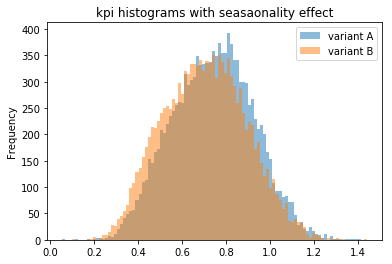

In [278]:
to_KPI_per_variant(data_seaonality_effect).plot.hist(alpha=0.5, bins=100, title="kpi histograms with seasaonality effect")
plt.show()

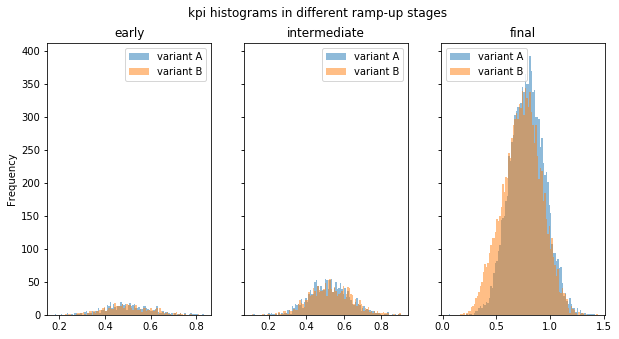

In [279]:
plot_by_stage(data_seaonality_effect, "kpi histograms in different ramp-up stages")

Here we noticed that the seasonality effect will lead to a big mean shift after the ramp-up phases. Both the means of treatment and control in the 50/50 stage are centered at about 0.8 instead of 0.5.

Now let's run the same evluation for different analysis approaches with mocked seasonality effect.

In [280]:
data1 = approach_staightforward(data_seaonality_effect)
data2 = approach_remove_rampup_data(data_seaonality_effect)
data3 = approach_exposure_time(data_seaonality_effect)
all_data = [(data1, 'Approach Staightforward'),
        (data2, 'Approach Remove ramp-up data'),
        (data3, 'Approach Exposure time')]

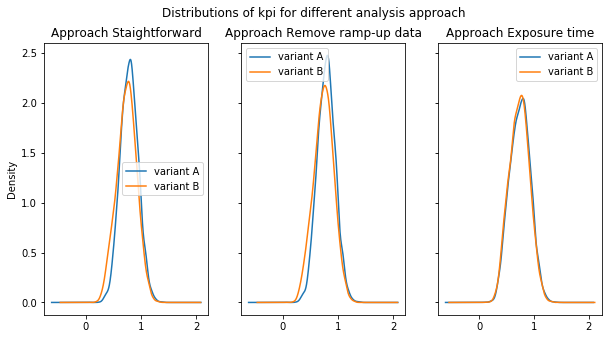

number of data:
Staightforward: 21223
Remove ramp-up data: 16534
Exposure time: 23212

percentage of treatment:
Staightforward: 49.84%
Remove ramp-up data: 49.72%
Exposure time: 44.90%


In [281]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5), sharey=True)

for data, axis in zip(all_data, axes):
    to_KPI_per_variant(data[0]).plot.kde(ax=axis)
    axis.set_title(data[1])
fig.suptitle("Distributions of kpi for different analysis approach")
plt.show()

n_ctr_1 = len(data1[data1.variant=='A'])
n_ctr_2 = len(data2[data2.variant=='A'])
n_ctr_3 = len(data3[data3.variant=='A'])
n_treat_1 = len(data1[data1.variant=='B'])
n_treat_2 = len(data2[data2.variant=='B'])
n_treat_3 = len(data3[data3.variant=='B'])

print("number of data:")
print("Staightforward:", len(data1))
print("Remove ramp-up data:", len(data2))
print("Exposure time:", len(data3))
print()
print("percentage of treatment:")
print("Staightforward: " + "{0:.2f}".format(n_treat_1/len(data1)*100) + "%")
print("Remove ramp-up data: " + "{0:.2f}".format(n_treat_2/len(data2)*100) + "%")
print("Exposure time: " + "{0:.2f}".format(n_treat_3/len(data3)*100) + "%")

We have the same observation as the evaluation in the section of effect of exposure.

# Conclusion

We drew the conclusion that if the implementation is not too difficult, the third analysis approach that uses data only within valid exposure time is the best. On the other hand, the staightfoward approach works almost as good as the removing ramp-up data.

However, these conclusion are sensitive to the assumped model of effect of exposure and seasonality effect. We will investigate these behaviour again once we have insights from real-world test data.

# Q & A

TODO!

* How to deal with ramp-up which are stopped (go back to 0% of traffic) or reduced (go back to lower % of traffic)? 

* Should we allow to decrease the amount or only increase?

* Should we control the length of the ramp-up period vs. experimentation period (e.g. force a ration of experiment 300% of the time actually needed for the ramp-ups, or force steps of variant weights like only 1% 15% / 25%)?

* What would be the influence of Sample Ratio Mismatch (SRM)? Is it necessary to include SRM as soon as ramp-ups are possible?